<a href="https://colab.research.google.com/github/cing3000/Reinforcement-Learning-An-Introduction/blob/master/Reinforcement_Learning_Notebook_Chapter_8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: Planning and Learning with Tabular Methods

Methods that require a model of the environment, such as dynamic programming and heuristic search, are called _model-based_ reinforcement learning methods.

Methods that can be used without a model, such Monte Carlo and temporal-difference methods, are called _model-free_ reinforcement learning methods.

Model-based methods rely on _planning_ as their primary component, while model-free methods primarily rely on _learning_.

## 8.1 Models and Planning

Distribution models: produce a description of all possibilities and their probabilities.
Sample models: product just one of the possibilities, sampled according to the probabilities.

We use the term _planning_ to refer to any computational process that takes a model as input and produces or imporoves a policy for interacting with the modeled environment.

State-space planning: is viewed primarily as a search through the state space for an optimal policy or an optimal path to a goal.

Plan-space planning: **?**

This common structure can be diagrammed as follows:

<img src="https://cdn-images-1.medium.com/max/1200/1*_mm9H3rRvaTseXEim47saw.png" width="800"/>

<font color='red'>The heart of both learning and planning methods is the estimation of value functions by backing-up update operations. The difference is that whereas planning uses simulated experience generated by a model, learning methods use real experience generated by the environment.</font>

** Random-sample one-step tabular Q-planning **

---
Do forever:
1. Select a state, $S\in\mathcal{S}$, and an action, $A \in\mathcal{A}(s)$, at random
1. Send $S$, $A$ to a sample model, and obtain: a sample next reward, $R$, and a sample next state, $S'$
1. Apply one-step tabular Q-learning to $S$, $A$, $R$, $S'$:
>$Q(S,A)\leftarrow Q(S,A)+\alpha\big[R+\gamma \max_aQ(S',a)-Q(S,A)\big]$
---


## 8.2 Dyna: Integrating Plannning, Acting and Learning

**Dyna-Q**: a simple architecture integrating the major functions needed in an on-line planning agent.

<img src="https://cdn-images-1.medium.com/max/800/1*XU8ikxAFcn942MueCXK1aw.png" width="600" />

Dyna-Q includes all of the processes shown in Figure 8.1, all occurring continuously. The planning method is the random-sample one-step tabular Q-planning method. The direct RL method is one-step tabular Q-learning. The model-learning method is also table-based and assumes the environment is deterministic. After each transition $S_t,A_t \rightarrow R_{t+1},S_{t+1}$, the model records in its table entry for $S_t, A_t$ the prediction that $R_{t+1}, S_{t+1}$ will deterministically follow. The model is never queried with a pair about which it has no information.

** Tabular Dyna-Q **

---
Initialize $Q(s,a)$ and $Model(s,a)$ for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$<br/>
Do forever:
1. $S \leftarrow$ current (nonterminal) state
1. $A \leftarrow \epsilon\text{-greedy}(S,Q)$
1. Execute action $A$; observe resultant reward, $R$, and state, $S'$
1. $Q(S,A) \leftarrow Q(S,A)+\alpha\big[R+\gamma\max_aQ(S',a)-Q(S,A)\big]$
1. $Model(S,A)\leftarrow R,S'$ (assuming deterministic environment)
1. Repeat $n$ times:
>$S \leftarrow$ random previously observed state<br/>
>$A \leftarrow $ random action previously taken in $S$<br/>
>$R, S' \leftarrow Model(S,A)$<br/>
>$Q(S,A) \leftarrow Q(S,A)+\alpha\big[R+\gamma\max_aQ(S',a)-Q(S,A)\big]$

---


** Example 8.1: Dyna Maze **


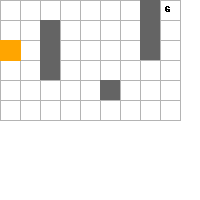
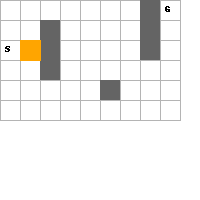
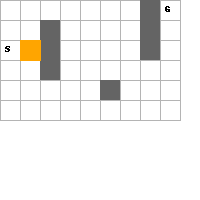
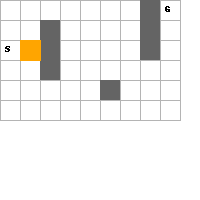
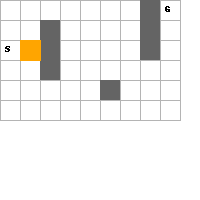
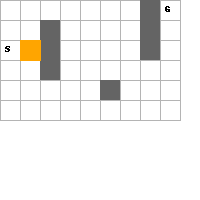
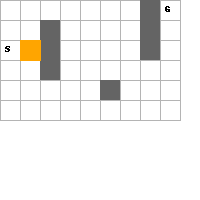
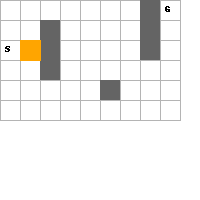
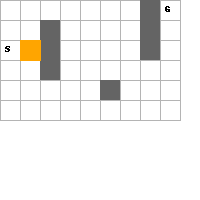
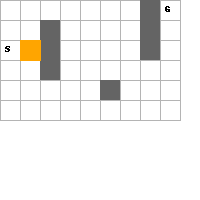
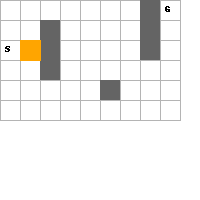
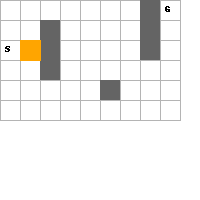
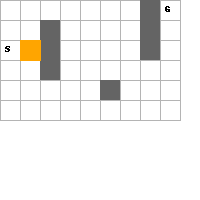
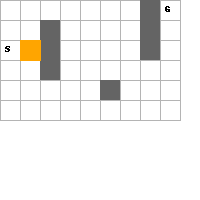
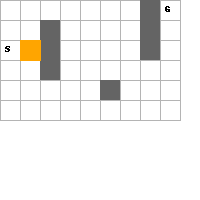
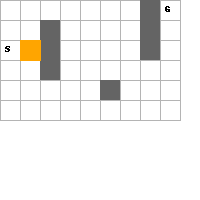
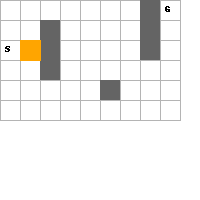
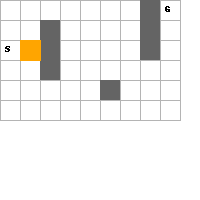
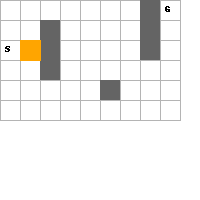
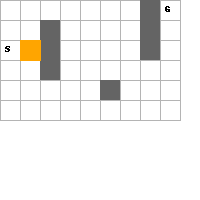
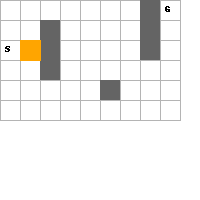
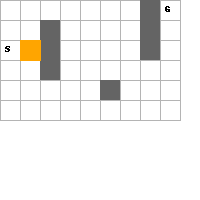
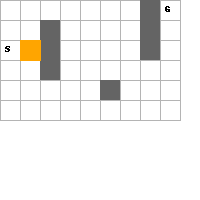
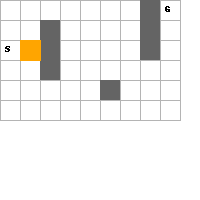
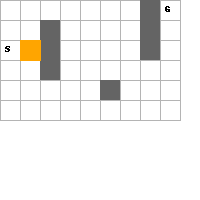
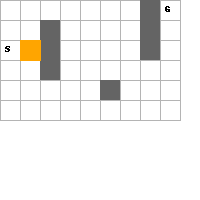
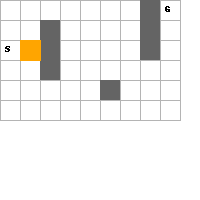
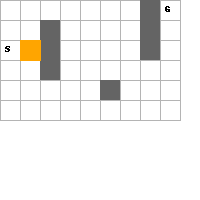
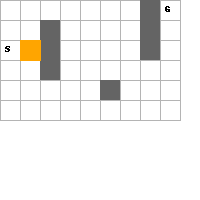
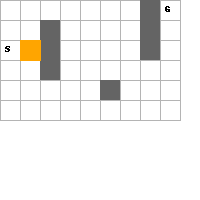
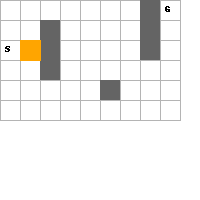
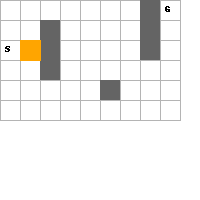
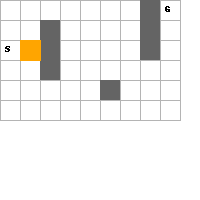
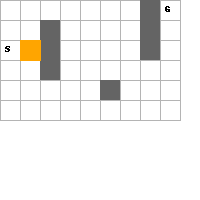
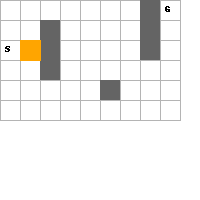
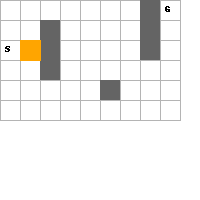
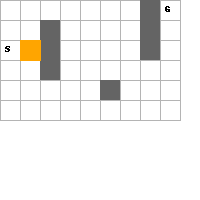
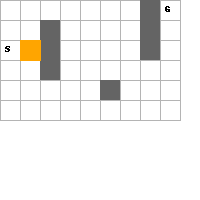
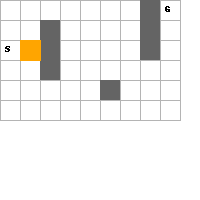
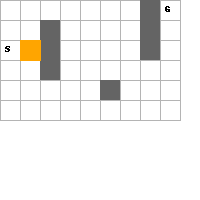
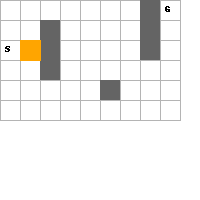
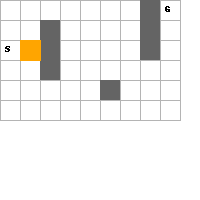
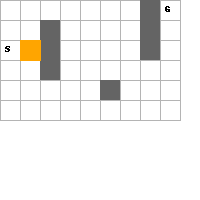
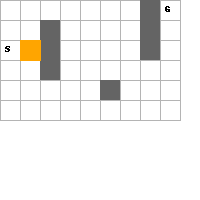
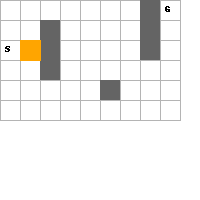
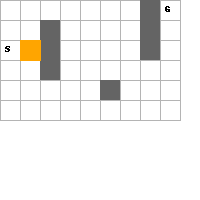
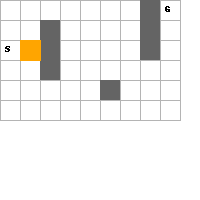
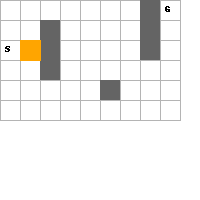
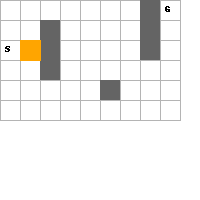
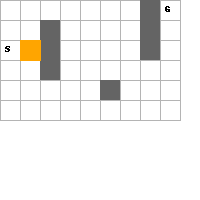
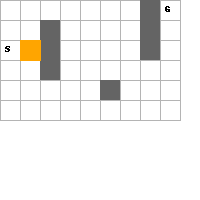
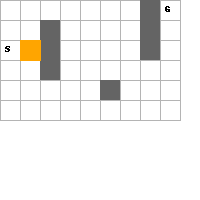
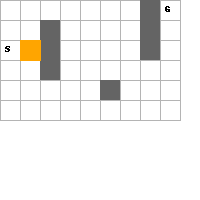
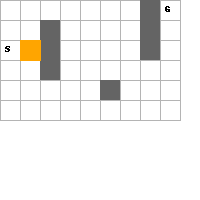
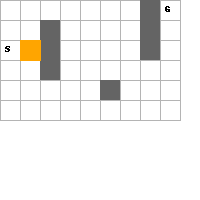
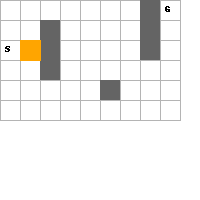
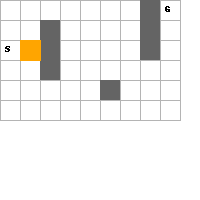
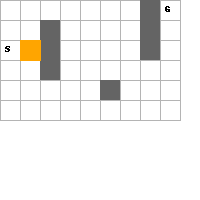
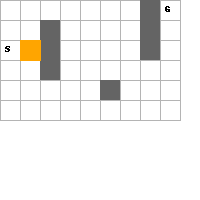
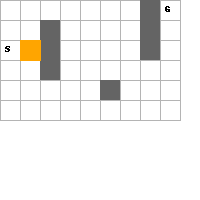
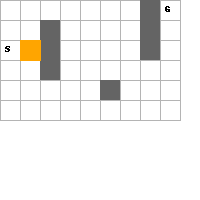
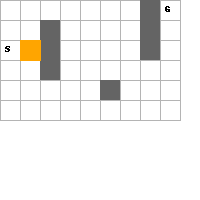
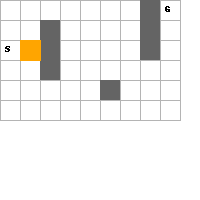
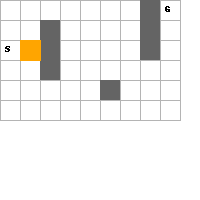
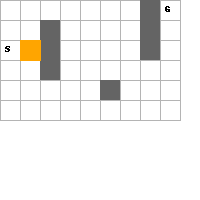
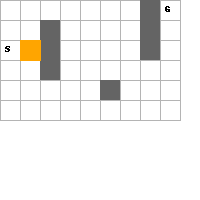
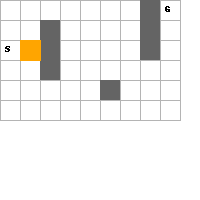
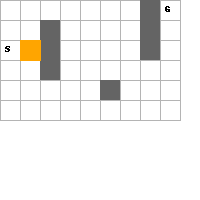
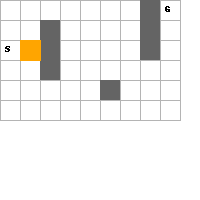
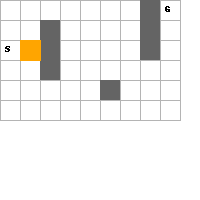
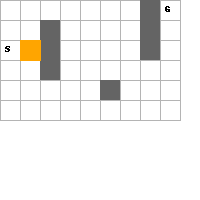
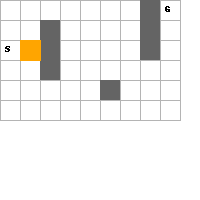
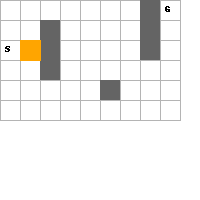
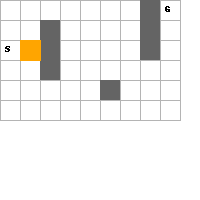
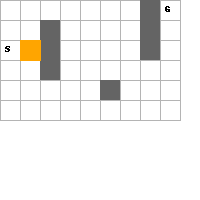
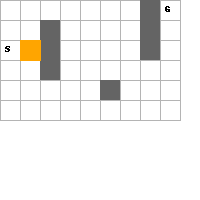
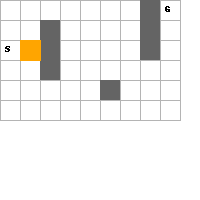
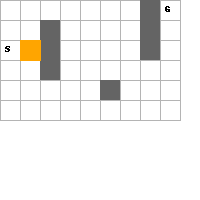
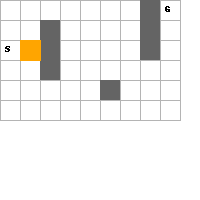
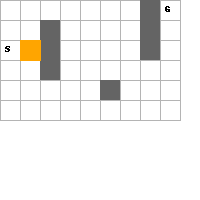
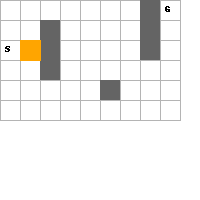
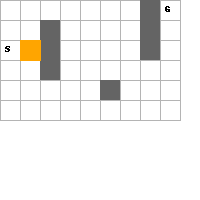
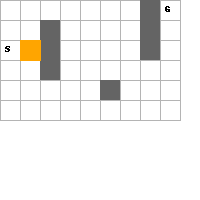
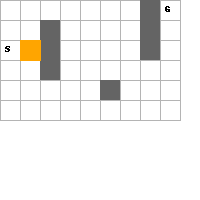
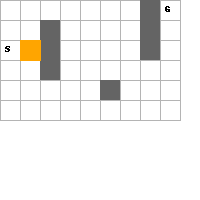
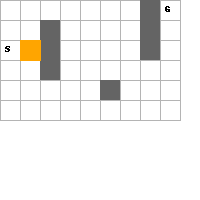
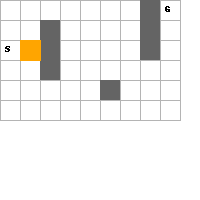
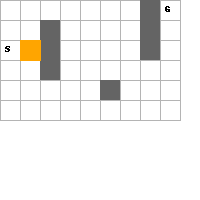
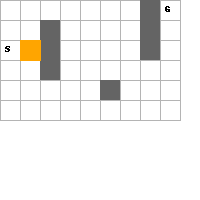
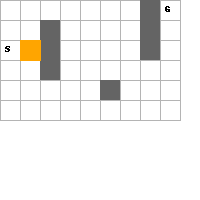
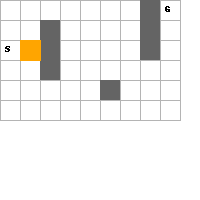
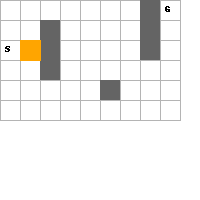
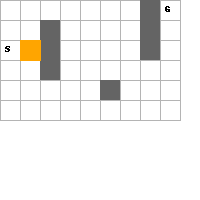
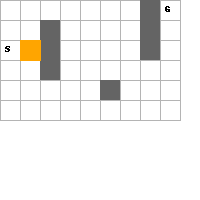
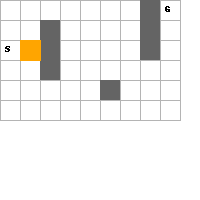
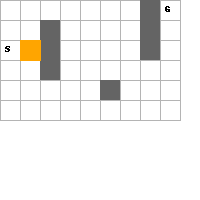
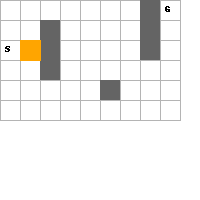
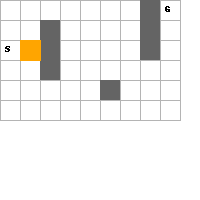
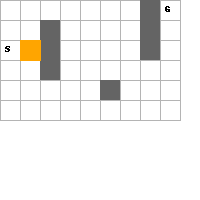
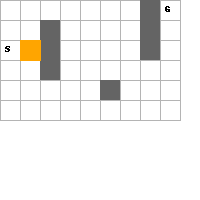
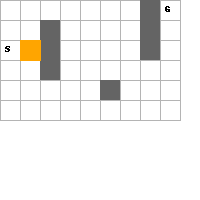
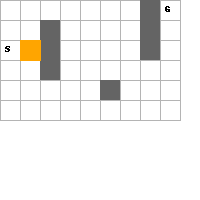
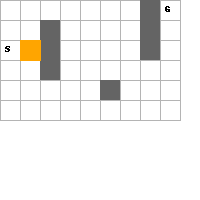
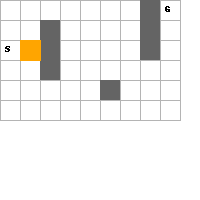
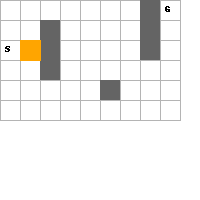
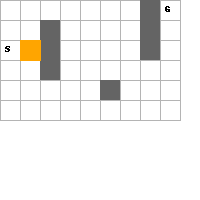
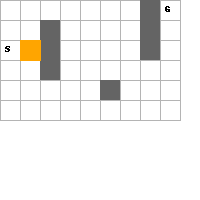
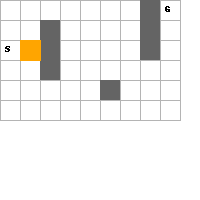
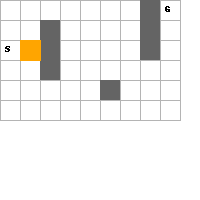
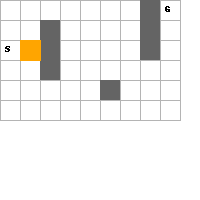
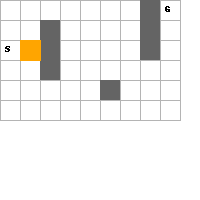
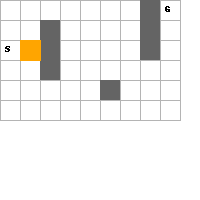
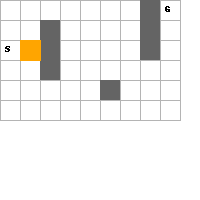
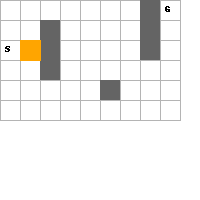
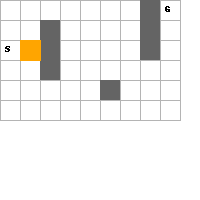
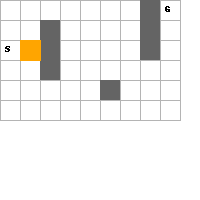
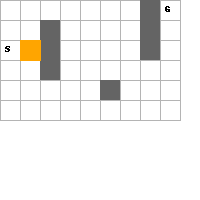
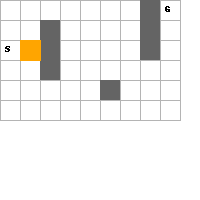
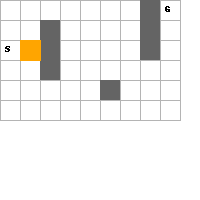
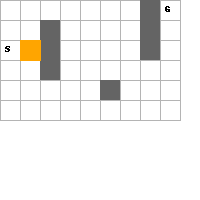
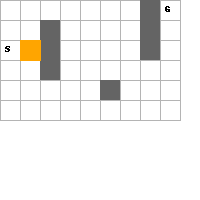
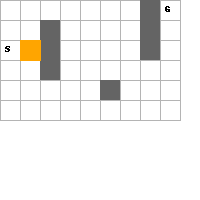
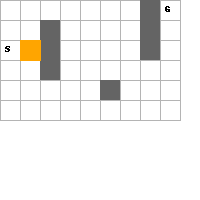
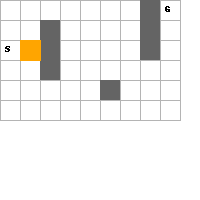
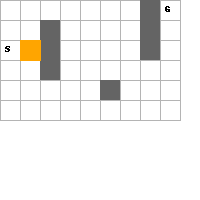
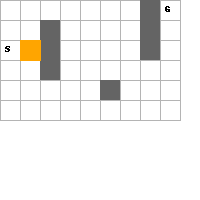
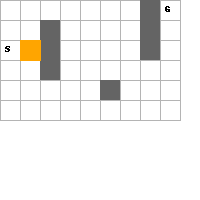
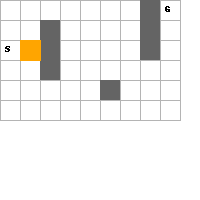
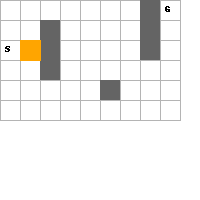
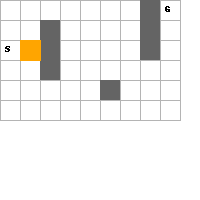
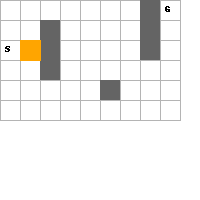
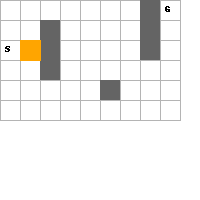
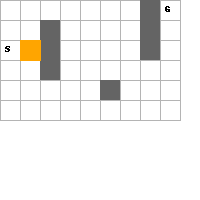
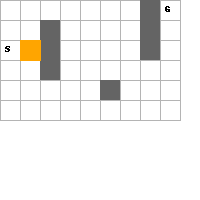
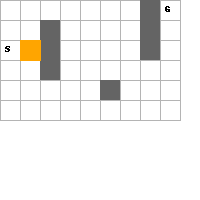
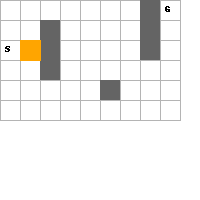
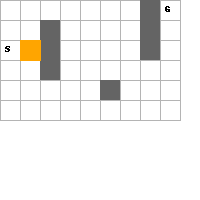
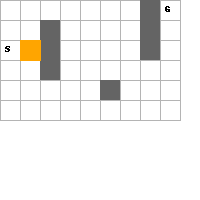
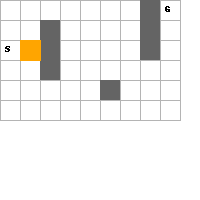
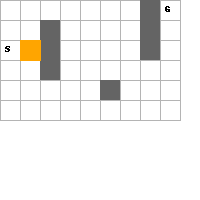
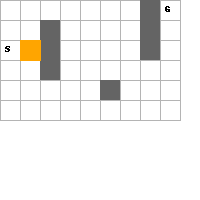
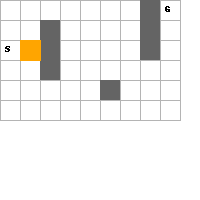
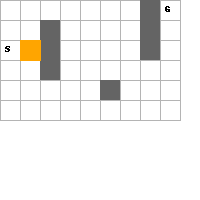
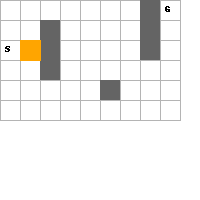
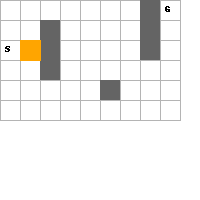
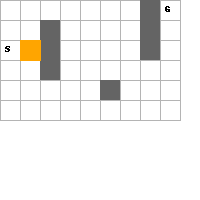
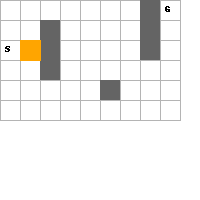
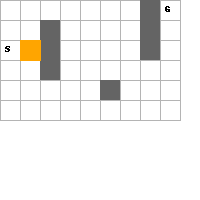
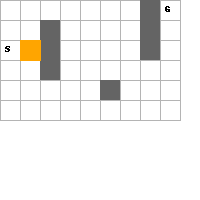
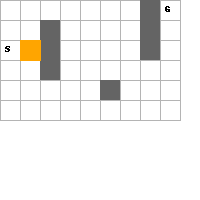
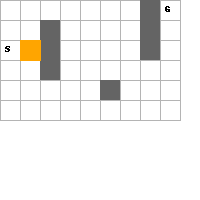
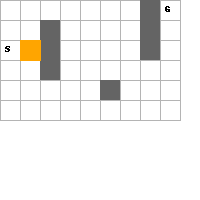
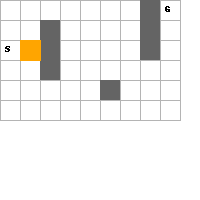
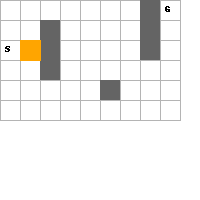
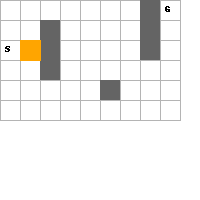
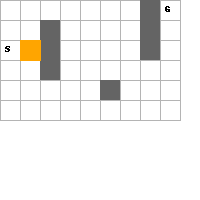
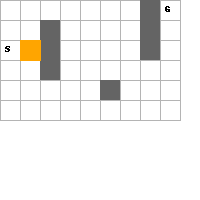
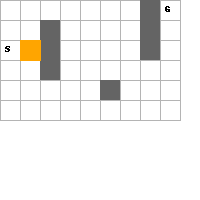
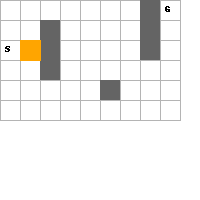
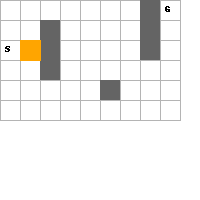
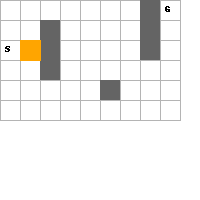
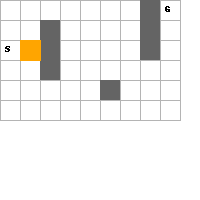
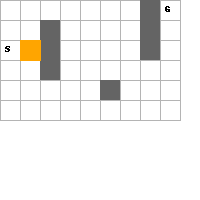
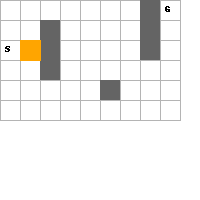
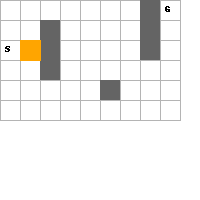
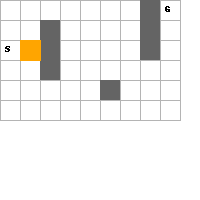
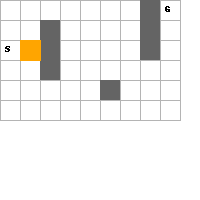
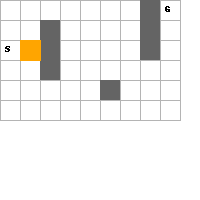
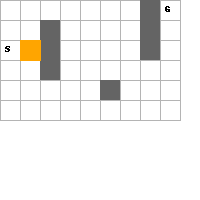
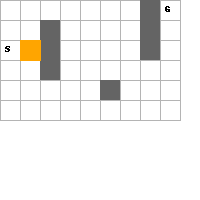
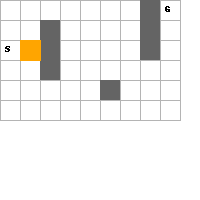
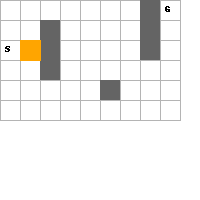
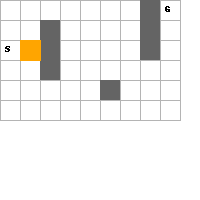
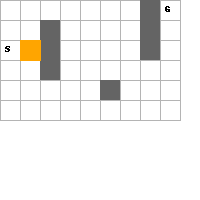
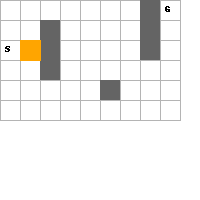
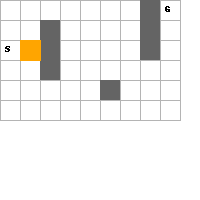
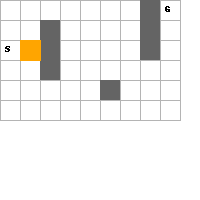
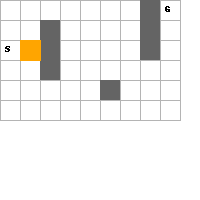
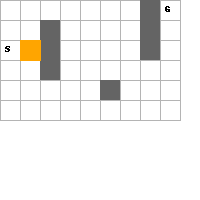
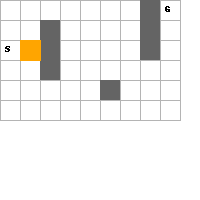
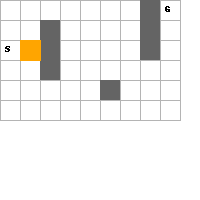
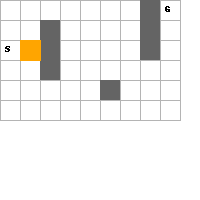
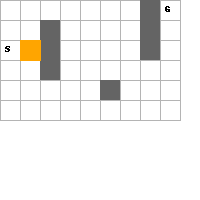
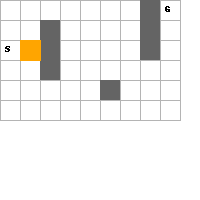
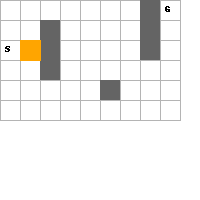
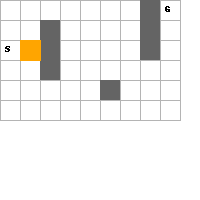
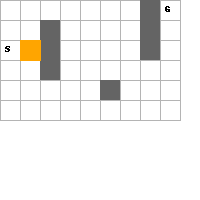
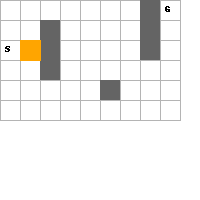
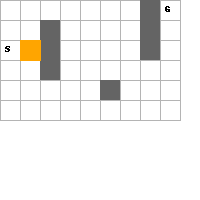
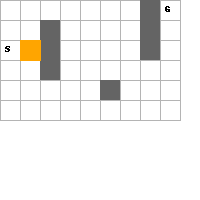
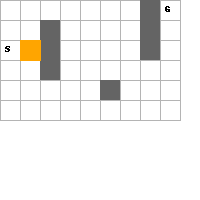
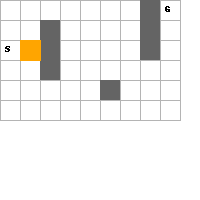
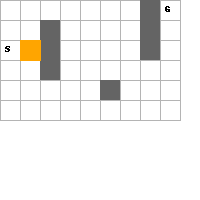
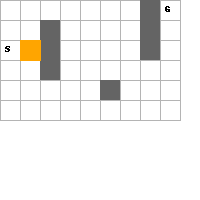
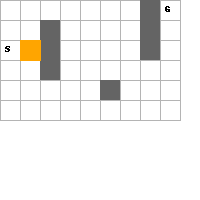
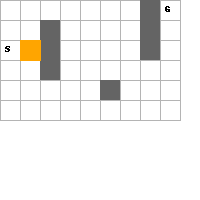
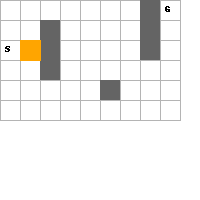
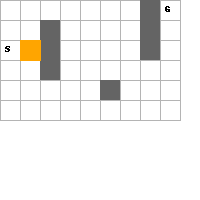
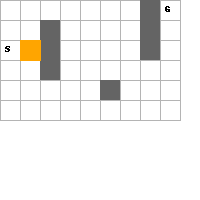
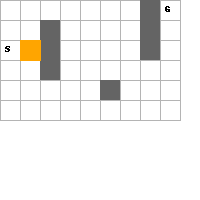


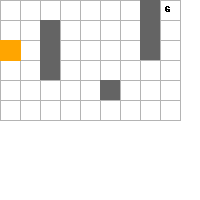
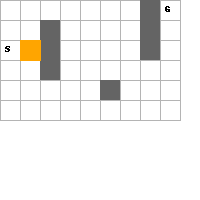
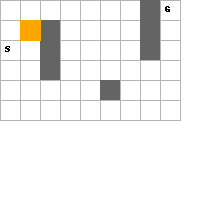
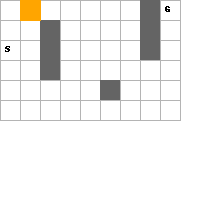
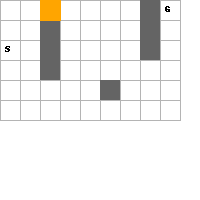
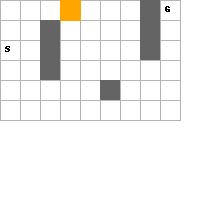
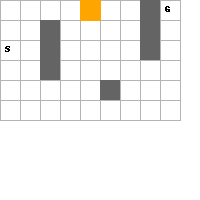
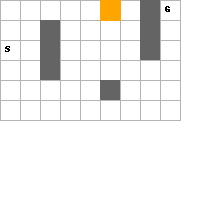
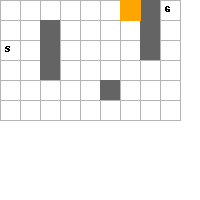
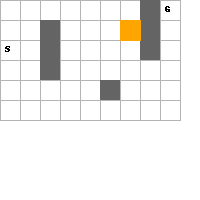
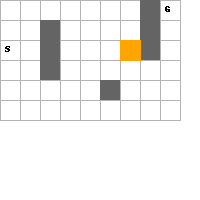
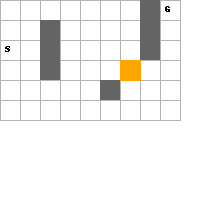
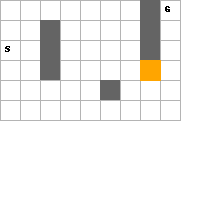
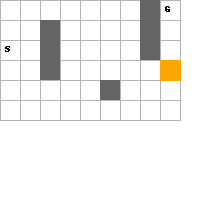
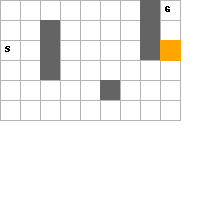
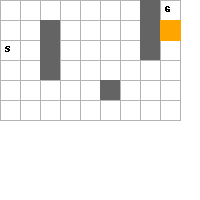

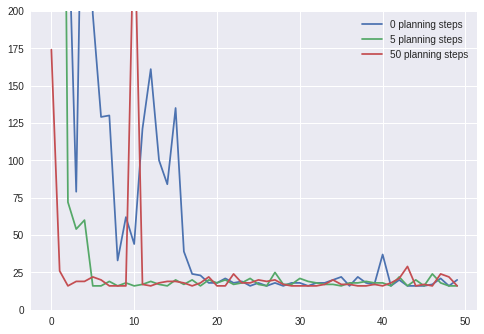

In [0]:
import numpy as np
from IPython.display import display, HTML, Javascript
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time, random

MAZE = {'start': (0, 2), 'goal': (8, 0), 'maze': [
    [0,0,0,0,0,0,0,1,3], [0,0,1,0,0,0,0,1,0], [2,0,1,0,0,0,0,1,0],
    [0,0,1,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,0,0,0]]}

# 4 actions, right, left, down, and up
ACTION_SPACE = [[1,0], [-1,0], [0,1], [0,-1]]
A = len(ACTION_SPACE)

# block size for display
BS = 20

# display frames
def display_frames(frames):
    
    import base64, uuid
    from io import BytesIO
    
    obj_id = "ani_" + str(uuid.uuid4()).replace('-', '')
    img_id = "img_" + str(uuid.uuid4()).replace('-', '')
    slider_id = "sli_" + str(uuid.uuid4()).replace('-', '')
    loop_id = "loop_" + str(uuid.uuid4()).replace('-', '')
    javascript = "<link rel=\"stylesheet\" href=\"https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesome.min.css\"><script language=\"javascript\">"
    javascript += "function Animation(t,i,e,r,n){this.img_id=i,this.slider_id=e,this.loop_select_id=n,this.interval=r,this.current_frame=0,this.direction=0,this.timer=null,this.frames=new Array(t.length);"
    javascript += "for(var s=0;s<t.length;s++)this.frames[s]=new Image,this.frames[s].src=t[s];document.getElementById(this.slider_id).max=this.frames.length-1,this.set_frame(this.current_frame)}Animation."
    javascript += "prototype.get_loop_state=function(){for(var t=document[this.loop_select_id].state,i=0;i<t.length;i++){var e=t[i];if(e.checked)return e.value}},Animation.prototype.set_frame=function(t)"
    javascript += "{this.current_frame=t,document.getElementById(this.img_id).src=this.frames[this.current_frame].src,document.getElementById(this.slider_id).value=this.current_frame},Animation.prototype."
    javascript += "next_frame=function(){this.set_frame(Math.min(this.frames.length-1,this.current_frame+1))},Animation.prototype.previous_frame=function(){this.set_frame(Math.max(0,this.current_frame-1))},"
    javascript += "Animation.prototype.first_frame=function(){this.set_frame(0)},Animation.prototype.last_frame=function(){this.set_frame(this.frames.length-1)},Animation.prototype.slower=function(){this.interval/=.7,0"
    javascript += "<this.direction?this.play_animation():this.direction<0&&this.reverse_animation()},Animation.prototype.faster=function(){this.interval*=.7,0<this.direction?this.play_animation():this.direction<0&&this."
    javascript += "reverse_animation()},Animation.prototype.anim_step_forward=function(){if(this.current_frame+=1,this.current_frame<this.frames.length)this.set_frame(this.current_frame);else{var t=this.get_loop_state();"
    javascript += "\"loop\"==t?this.first_frame():\"reflect\"==t?(this.last_frame(),this.reverse_animation()):(this.pause_animation(),this.last_frame())}},Animation.prototype.anim_step_reverse=function(){if(this.current_"
    javascript += "frame-=1,0<=this.current_frame)this.set_frame(this.current_frame);else{var t=this.get_loop_state();\"loop\"==t?this.last_frame():\"reflect\"==t?(this.first_frame(),this.play_animation()):(this.pause_animation(),this.first_frame())}},Animation.prototype.pause_animation=function(){this.direction=0,this.timer&&(clearInterval(this.timer),this.timer=null)},Animation.prototype.play_animation=function(){this.pause_animation(),this.direction=1;var t=this;this.timer||(this.timer=setInterval(function(){t.anim_step_forward()},this.interval))},Animation.prototype.reverse_animation=function(){this.pause_animation(),this.direction=-1;var t=this;this.timer||(this.timer=setInterval(function(){t.anim_step_reverse()},this.interval))};</script>"
    
    html = "<div class=\"animation\" align=\"center\"><img id=\"" + img_id + "\"><br><input id=\"" + slider_id + "\" type=\"range\" style=\"width:350px\" name=\"points\" min=\"0\" max=\"1\" step=\"1\" value=\"0\" onchange=\"" + obj_id + ".set_frame(parseInt(this.value));\"></input><br><button onclick=\"" + obj_id + ".slower()\"><i class=\"fa fa-minus\"></i></button><button onclick=\"" + obj_id + ".first_frame()\"><i class=\"fa fa-fast-backward\"></i></button><button onclick=\"" + obj_id + ".previous_frame()\"><i class=\"fa fa-step-backward\"></i></button><button onclick=\"" + obj_id + ".reverse_animation()\"><i class=\"fa fa-play fa-flip-horizontal\"></i></button><button onclick=\"" + obj_id + ".pause_animation()\"><i class=\"fa fa-pause\"></i></button><button onclick=\"" + obj_id + ".play_animation()\"><i class=\"fa fa-play\"></i></button><button onclick=\"" + obj_id + ".next_frame()\"><i class=\"fa fa-step-forward\"></i></button><button onclick=\"" + obj_id + ".last_frame()\"><i class=\"fa fa-fast-forward\"></i></button><button onclick=\"" + obj_id + ".faster()\"><i class=\"fa fa-plus\"></i></button><form action=\"#n\" name=\"" + loop_id + "\" class=\"anim_control\"><input type=\"radio\" name=\"state\"  value=\"once\" > Once</input><input type=\"radio\" name=\"state\" value=\"loop\" checked> Loop</input><input type=\"radio\" name=\"state\" value=\"reflect\" > Reflect</input></form></div>"
    html += "<script language=\"javascript\">(function(){var img_id = \"%s\";var slider_id=\"%s\";var loop_select_id=\"%s\";var frames = new Array(0);" % (img_id, slider_id, loop_id)

    for i, frame in enumerate(frames):
        buf = BytesIO()
        frame.save(buf, format="PNG")
        imgstr = base64.b64encode(buf.getvalue()).decode('ascii')
        html += "frames[%d] = \"data:image/png;base64,%s\";" % (i,imgstr)
        
    html += "setTimeout(function() {%s = new Animation(frames, img_id, slider_id, 200.0, loop_select_id);}, 0);})()</script>" % obj_id

    display(HTML(javascript + html))

class DynaMaze:
    
    def __init__(self):
        
        self.Q = None
        self.p = None
        
        self.generate()
        self.reset()
    
    #
    # track is presented by a w * h grid
    #    available posistion uses 1
    #    out-of-border marked as 0
    #    start: 2, finish: 3
    #
    def generate(self):
        
        self.start = MAZE['start']
        self.goal = MAZE['goal']
        self.maze = np.array(MAZE['maze'])
        
        self.width = self.maze.shape[1]
        self.height = self.maze.shape[0]

    # reset position and Q
    def reset(self):
        self.p = self.start

    # visualize environment
    def draw(self):
        img = Image.new('RGB', (200, 200), (255,255,255))
        d = ImageDraw.Draw(img)
        
        # draw grid
        for x in range(self.width):
            for y in range(self.height):
                if self.maze[y, x] == 0:
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], outline=(180,180,180))
                elif self.maze[y, x] == 1:
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], fill=(100,100,100))
                elif self.maze[y, x] == 2:
                    d.text([x*BS+5, y*BS+3], "S", fill='black')
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], outline=(180,180,180))
                elif self.maze[y, x] == 3:
                    d.rectangle([x*BS, y*BS, (x+1)*BS, (y+1)*BS], outline=(180,180,180))
                    d.text([x*BS+5, y*BS+3], "G", fill='black')
        
        # draw agent
        d.rectangle([self.p[0]*BS, self.p[1]*BS, (self.p[0]+1)*BS, (self.p[1]+1)*BS], fill='orange')
        
        # print Q
        #text = "Action    RIGHT      LEFT     DOWN       UP\n"
        #text += "    "
        #for i, _ in enumerate(ACTION_SPACE):
        #    text += "    %.2f" % self.Q[self.p[0], self.p[1], i]
        #d.multiline_text((300, 100), text, fill='black', spacing=10)

        return img

    # one step
    def step(self, a):
        
        action = ACTION_SPACE[a]
        x, y = self.p
        
        # finish flag
        done = False
        r = 0
        
        # move
        new_x = x + action[0]
        new_y = y + action[1]
        
        # check the new position
        if new_x < 0 or new_x >= self.width or new_y < 0 or new_y >= self.height or self.maze[new_y, new_x] == 1:
            # out or hit obstacle, don't move
            new_x = x
            new_y = y
        elif self.maze[new_y, new_x] == 3:
            r = 1
            done = True
        
        # update to new position
        self.p = (new_x, new_y)
            
        return self.p, r, done

    
    def episode(self, policy, Q, verbose=False):

        # initialize
        step = 0
        frames = []
        done = False

        # states and actions recorder
        s_list = []
        a_list = []

        # run
        while step < 200 and not done:
            
            # visualize current environment
            if verbose:
                frames.append(self.draw())
            
            # generate action
            a, _ = policy(self.p, Q)
            
            # record
            s_list.append(self.p)
            a_list.append(a)
            
            # go one step
            s, r, done = self.step(a)
            
            step += 1
    
        return s_list, a_list, r, frames


# initialize env
maze = DynaMaze()


# random policy
def policy_random(state, Q):
    return np.random.randint(0, len(ACTION_SPACE)), 1/len(ACTION_SPACE)

# epsilon-greedy policy
epsilon = 0.1
ep_avg = epsilon/A
def policy_e_greedy(state, Q):
    greedy_action = np.argmax(Q[state[0], state[1]])
    probs = [ep_avg] * (A-1)
    probs.insert(greedy_action, 1-epsilon+ep_avg)
    action = np.random.choice(A, p=probs)
    return action, probs[action]

# target greedy policy
def policy_greedy(state, Q):
    greedy_action = np.argmax(Q[state[0], state[1]])
    return greedy_action, 1


# validation
def valid(epoch, elapsed):
    rt.reset()
    _, actions, reward, frames = rt.episode(policy_greedy, verbose=False)
    if reward == 1:
        print("%d epoches run in %.2f secs, validate result: finish in %d" % (epoch+1, elapsed, len(actions)))
        #display_frames(frames)
    else:
        print("%d epoches run in %.2f secs, validate result: cannot finish" % (epoch+1, elapsed))

    #display_frames(frames)


#
# Learning and planning 
#

# number of epoches
epoches = 50
checkpoint = 2000


# Dyna-Q
def Dyna_Q(n, visual=False):
    
    # initialize hyper-parameters
    alpha = 0.1
    gamma = 0.95
    
    # initialize model and Q
    model = {}
    Q = np.zeros((maze.width, maze.height, A))
    
    # counters
    steps = []
    
    if visual:
        maze.reset()
        _, _, _, frames = maze.episode(policy_greedy, Q, verbose=True)
        display_frames(frames)

    # run epoches
    for epoch in range(epoches):
        
        # reset
        maze.reset()
        step = 0
        done = False
        
        while step < 1000 and not done:
            # initialize
            s = maze.p
            a, _ = policy_e_greedy(s, Q)

            # execute action a
            new_s, r, done = maze.step(a)

            # update Q
            a_prim = np.argmax(Q[new_s[0], new_s[1]])
            q = Q[s[0], s[1], a]
            Q[s[0], s[1], a] += alpha*(r+gamma*Q[new_s[0], new_s[1], a_prim]-q)

            # update model
            model[(s, a)] = (r, new_s)

            # move to new state
            s = new_s

            # model learning
            for i in range(n):
                #print(random.choice(list(model.items())))
                (s1, a1), (r1, new_s1) = random.choice(list(model.items()))

                # update Q
                a_prim1 = np.argmax(Q[new_s1[0], new_s1[1]])
                q = Q[s1[0], s1[1], a1]
                Q[s1[0], s1[1], a1] += alpha*(r1+gamma*Q[new_s1[0], new_s1[1], a_prim1]-q)


            # update step
            step += 1

        # record steps
        steps.append(step)
    
    # visualize result
    if visual:
        maze.reset()
        _, _, _, frames = maze.episode(policy_greedy, Q, verbose=True)
        display_frames(frames)
    
    return steps


# train
d0 = Dyna_Q(0)
d5 = Dyna_Q(5)
d50 = Dyna_Q(50, True)

plt.plot(d0, label='0 planning steps')
plt.plot(d5, label='5 planning steps')
plt.plot(d50, label='50 planning steps')
plt.ylim(0, 200)
plt.legend()
plt.show()

#rt.reset()
#_, _, _, frames = rt.episode(policy_greedy, verbose=True, noise=False)
#display_frames(frames)

## 8.3 When the Model Is Wrong

Model may be incorrect because
* the enviornment is stochastic and only a limited number of samples have been observed,
* or because the model was learned using function aproximation that has generalized imperfectly,
* or simple because the environment has changed and its new behavior has not yet been observed.

** Dyna-Q+** If the modeled reward for a transition is $r$, and the transition has not been tried in $\tau$ time steps, then planning updates are done as if that transition produced a reward of $r+\kappa\sqrt{\tau}$, for some small $\kappa$.

## 8.4 Prioritiezed Sweeping

In the Dyna agents, simulated transitions are started in state-action pairs selected uniformly at random from all previously experienced pairs. But a uniform selection is usually not the best; planning can be much more efficient if simulated transitions and updates are focused on particular state-action pairs.

One can work backward from arbitrary states that have changed in value, either performing useful updates or terminating the propagation. This general idea might be termed **backward focusing** of planning computations.

** Prioritized sweeping for a deterministic environment **

---
Initialize $Q(s,a)$, $Model(s,a)$, for all $s$, $a$, and $PQueue$ to empty<br/>
Do forever:
>$S\leftarrow$ current (nonterminal) state<br/>
>$A\leftarrow policy(S,Q)$<br/>
>Execute action $A$; observe resultant reward, $R$, and state, $S'$<br/>
>$Model(S,A)\leftarrow R,S'$<br/>
>$P\leftarrow \mid R+\gamma\max_aQ(S',a)-Q(S,A)\mid $<br/>
>if $P \gt \theta$, then insert $S$, $A$ into $PQueue$ with priority $P$<br/>
>Repeat $n$ times while $PQueue$ is not empty:
>>$S,A\leftarrow first(PQueue)$<br/>
>>$R,S' \leftarrow Model(S,A)$<br/>
>>$Q(S,A)\leftarrow Q(S, A) + \alpha\big[R+\gamma\max_aQ(S',a)-Q(S,A)\big]$<br/>
>>Repeat, for all $\bar{S}$,$\bar{A}$ predicted to lead to $S$:
>>>$\bar{R}\leftarrow$ predicted reward for $\bar{S}$, $\bar{A}$, $S$<br/>
>>>$P\leftarrow\mid \bar{R}+\gamma\max_aQ(S',a)-Q(\bar{S},\bar{A})\mid $<br/>
>>>if $P \gt \theta$ then insert $\bar{S}$, $\bar{A}$ into $PQueue$ with priority $P$.

---



## 8.5 Expected vs. Sample Updates

Different kinds of value-function updates vary primarily along three binary dimensions:
* whether they update state values or action values (<font color='blue'>$Q$ or $V$</font>)
* whether they estimate the value for the optimal policy or for an arbitrary given policy (<font color='blue'>on-policy or off-policy</font>)
* whether the updates are exptected updates, considering all possible events that might happen, or sample updates, considering a sinle sample of what might happen(<font color='blue'>$\mathbb{E}[Q(S',A'|S')]$ or $Q(S', argmax_aQ(S', a))$</font>)

In the absence of a distribution model, expected updates are not possible.

Expected updates certainly yield a better estimate because they are uncorrupted by sampling error, but they also require more computation.

Expected update vs. sample updates:
$$Q(s,a)\leftarrow \sum_{s',r}\hat{p}(s',r|s,a)\Big[r + \gamma\max_{a'}Q(s',a')\Big] \tag{8.1}$$
$$Q(s,a)\leftarrow Q(s,a)+\alpha\Big[R+\gamma\max_{a'}Q(S',a')-Q(s,a)\Big] \tag{8.2}$$

In a real problem, the values of the successor states would be estimates that are themselves updated. By causing estimates to be more accurate sooner, sample updates will have a second advantage in that the values backed up from the successor states will be more accurate. These results suggest that <font color='red'>**sample updates are likely to be superior to expected updates on problems with large stochastic branching factors and too many states to be solved exactly**.</font>

## 8.6 Trajectory Sampling

Compare two ways of distribution updates.
* The classical approach, from dynamic programming, is to perform sweeps through the entire state (or state-aciton) space, updating each state (or state-action pair) once per sweep.
* The second approach is to sample from the state or state-action space according to some distribution. (e.g. Uniform distribution in Dyna-Q)

---

Repeat $n$ times:
>$S \leftarrow$ random previously observed state<br/>
>$A \leftarrow $ random action previously taken in $S$<br/>
>$R, A' \leftarrow Model(S,A)$<br/>
>$Q(S,A) \leftarrow Q(S,A)+\alpha\big[R+\gamma\max_aQ(S',a)-Q(S,A)\big]$

---

To distribute updates according to the on-policy distribution, that is, according to the distribution observed when following the current policy.

In other words, one simulates explicit individual trafectories and performs updates at the state of state-action pairs encountered along the way. We call this way of generating experience and updates _trajectory sampling_.

---

$S\leftarrow 0$<br/>
Repeat $n$ times:
>if $S$ is $0$, or $S$ is terminal state, then randomly pick a $S$ in observed state<br/>
>$A \leftarrow policy(S)$ in previously taken in $S$<br/>
>$R, S' \leftarrow Model(S,A)$<br/>
>$Q(S,A) \leftarrow Q(S,A)+\alpha\big[R+\gamma\max_aQ(S',a)-Q(S,A)\big]$<br/>
>$S \leftarrow S'$
---

Focusing on the on-policy distribution could be beneficial because it causes vast, uninteresting parts of the space to be ignored, or it could be detrimental because it causes the same old parts of the space to be updated over and over.

<br/>

In the long run, focusing on the on-policy distribution may hurt because the commonly occurring states all already have their correct
values. Sampling them is useless, whereas sampling other states may actually perform some useful work.

## 8.7 Real-time Dynamic Programming

** Real-time dynamic programming **, or RTDP, is an on-policy trajectory-sampling version of DP's value-iteration algorithm.

Unreachable states are irrelevant to the prediction problem.

For a control problem, what is needed is an optimal partial policy, meaning a policy that is optimal for the relevant states but can specify arbitrary actions, or even be undefined, for the irrelevant states.



## 8.8 Planning at Decision Time

Use planning to gradually improve a policy or value function on the basis of simulated experience obtained from a model. Selecting actions is then a matter of comparing the current state's action values. Used this way, plainning is not focussed on the current state. We call planning used in this way _**background planning**_.

The other way to use planning is to begin and complete it after encountering each new state $S_t$. Here planning focuses on a particular state. We call this _**decision-time planning**_.

Decision-time planning is most useful in applications in which fast responses are not required. In chess playing programs, for example, one may be permitted seconds or minutes of computation for each move, and strong programs may plan dozens of moves ahead within this time. On the other hand, if low latency action selection is the priority, then one is generally better of doing planning in the background to compute a policy that can then be rapidly applied to each newly encountered state.

## 8.9 Heuristic Search

The classical state-space planning methods in artificial intelligence are decision-time planning methods collectively known as **_heuristic search_**.

Heuristic search can be viewed as an extension of the idea of a greedy policy beyond a single step.



## 8.10 Rollout Algorithms

Rollout algorithms are decision-time planning algorithms based on Monte Carlo control applied to simulated trajectories that all begin at the current environment state.

They estimate action values for a given policy by averaging the returns of many simulated trajectories that start with each possible action and then follow the given policy.

## 8.11 Monte Carlo Tree Search

Each iteration of a basic version of MCTS consists of the following four steps:
1. **Selection**. Starting at the root node, a _tree policy_ based on the action values attached to the edges of the tree traverses the tree to select a leaf node.
1. **Expansion**. On some iterations (depending on details of the application), the tree is expanded from the selected leaf node by adding one or more child nodes reached from the selected node via unexplored actions.
1. **Simulation**. From the selected node, or from one of its newly-added child nodes (if any), simulation of a complete episode is run with actions selected by the rollout policy. The result is a Monte Carlo trial with actions selected first by the tree policy and beyond the tree by the rollout policy.
1. **Backup**. The return generated by the simulated episode is backed up to update, or to initialize, the action values attached to the edges of the tree traversed by the tree policy in this iteration of MCTS. No values are saved for the states and actions visited by the rollout policy beyond the tree.

<img src="https://gdurl.com/lq3F" width="600"/>

MCTS continues executing these four steps, starting each time at the tree's root node, until no more time is left, or some other computational resource is exhausted. Then, finally, an action from the root node (which still represents the current state of the environment) is selected according to some mechanism that depends on the accumulated statistics in the tree.

<font color='blue'>

** Monte Carlo Tree Search **

---
Initialize explored state tree $\mathcal{T}(s)$ to empty<br/>
$S_{0}\leftarrow $ current state <br/>
While resource (time, computational power, ...) left
>Initialize $Returns(S_0)$ and $Trajectory(S_0)$ to empty list<br/>
>$S\leftarrow S_{0}$<br/>
>Loop until $S$ is leaf node under $\mathcal{T}(S_0)$
>>$A\leftarrow \pi_{tree}(S)$<br/>
>>$S', R\leftarrow Model(S, A)$<br/>
>>Append $R$ to $Returns(S_0)$, $S',A$ to $Trajectory(S_0)$<br/>
>>$S\leftarrow S'$

>if $\text{condition}$
>>$A \leftarrow \pi_{tree}(S)$<br/>
>>$S', R\leftarrow Model(S,A)$<br/>
>>Append $S'$ under $\mathcal{T}(S)$<br/>
>>Append $R$ to $Returns(S_0)$, $S',A$ to $Trajectory(S_0)$<br/>
>>$S \leftarrow S'$

>Loop until $S$ is terminate
>>$A \leftarrow \pi_{rollout}(S)$<br/>
>>$S', R \leftarrow Model(S, A)$<br/>
>>Append $R$ to $Returns(S_0)$, $S',A$ to $Trajectory(S_0)$<br/>
>>$S \leftarrow S'$

>Use $Returns(S_0)$ to update $Q(S, A)$ for all $S,A \in Trajectory(S_0)$

Use $Q(S, A)$ to decide best $A$ for $S_0$

---

## 8.13 Summary of Part I: Dimensions

<img src="https://gdurl.com/9uQf" width="600" />

Dimensions:
* Horizontal in the figure, whether they are sample updates or expected udpates
* Vertial is the degree of bottstrapping
* The binary distinction between on-policy and off-policy methods
* Definition of return: is the task episodic or continuing, discounted or undiscounted?
* Action values vs. state values vs. afterstate values
* Action selection/exploration
* Synchronous vs. asynchronous: are the updates for all states performed simultaneously or one by one in some order?
* Real vs. simulated
* Location of updates
* Timing of updates
* Memory for updates

# Chapter 9: On-policy Prediction with Approximation

The approximate value function is represented not as a table but as a parameterized functional form with weight vector $\mathbf{w}\in\mathbb{R}^d$.

We will write $\hat{v}(s,\mathbf{w})\approx v_\pi(s)$ for the approximate value of state $s$ given weight vector $\mathbf{w}$.

## 9.1 Value-function Approximation

An individual update by the notation $s \mapsto u$:
* Monte Carlo: $S_t \mapsto G_t$
* TD(0): $S_t \mapsto R_{t+1}+\gamma\hat{v}(S_{t+1}, \mathbf{w}_t)$
* n-step TD: $S_t \mapsto G_{t:t+n}$
* DP: $s\mapsto \mathbb{E}[R_{t+1}+\gamma\hat{v}(S_{t+1}, \mathbf{w}_t) | S_t = s]$


In principle, we can use any method for supervised learning from examples, including artificial neural networks, decision trees, and various kinds of multivariate regression.

## 9.2 The Prediction Objective ($\overline{VE}$)

By assumption we have far more states than weights, so making one state's estimate more accurate invariably means making others' less accurate. We must specify a _state weighting_ or distribution $\mu(s) \ge 0, \sum_s\mu(s)=1$, representing how much we care about the error in each state $s$.

**Mean Squared Value Error **, denoted $\overline{VE}$:
$$\overline{VE}(\mathbf{w})\doteq \sum_{s\in\mathcal{S}}\mu(s)\big[v_\pi(s)-\hat{v}(s, \mathbf{w})\big]^2 . \tag{9.1}$$

Often $\mu(s)$ is chosen to be the fraction of time spent in $s$.

## 9.3 Stochastic-gradient and Semi-gradient Methods

We assume that states appear in examples with the same distribution, $\mu$, over which we are rying to minimize the $\overline{VE}$.

SGD:
$$\mathbf{w}_{t+1}\doteq \mathbf{w}_t+\alpha\Big[v_\pi(S_t)-\hat{v}(S_t, \mathbf{w}_t)\Big]\nabla\hat{v}(S_t, \mathbf{w}_t), \tag{9.5} $$

The target output, denotd $U_t\in\mathbb{R}$, of the $t$th training example, $S_t\mapsto U_t$, is not the true value, $v_\pi(S_t)$, but some approximation to it.

$$\mathbf{w}_{t+1}\doteq \mathbf{w}_t+\alpha\Big[U_t-\hat{v}(S_t, \mathbf{w}_t)\Big]\nabla\hat{v}(S_t, \mathbf{w}_t), \tag{9.7} $$

<br/>

**Gradient Monte Carlo Algorithm for Estimating $\hat{v}\approx v_\pi$**

---
Input: the policy $\pi$ to be evaluated<br/>
Input: a differentiable function $\hat{v}: \mathcal{S}\times\mathbb{R}^d\rightarrow\mathbb{R}$

Initialize value-function weights $\mathbf{w}$ as appropriate (e.g., $\mathbf{w} = 0$)<br/>
Repeat forever:
>Generate an episode $S_0,A_0,R_1,S_1,A_1,\dots,R_T,S_T$ using $\pi$<br/>
>For $t = 0,1,\dots,T-1$:
>>$\mathbf{w}\leftarrow\mathbf{w}+\alpha\big[G_t-\hat{v}(S_t, \mathbf{w})\big]\nabla\hat{v}(S_t, \mathbf{w})$
---

One does not obtain the same guarantees if a bootstrapping estimate of $v_\pi(S_t)$ is used as the target $U_t$ in (9.7). Bootstraping targets such as $n$-step returns $G_{t:t+n}$ or the DP target $\sum_{a, s', r}\pi(a|S_t)p(s',r|S_t,a)[r+\gamma\hat{v}(s', \mathbf{w}_t)]$ all depend on the current value of the weight vector $\mathbf{w}_t$, which implies that they will be biased and that they will not produce a true gradient-descent method.

They include only a part of the gradient and we call them **semi-gradient methods**.

** Semi-gradient TD(0) for estimating $\hat{v}\approx v_\pi$**

---
Input: the policy $\pi$ to be evaluated<br/>
Input: a differentiable function $\hat{v}: \mathcal{S}^+\times\mathbb{R}^d\rightarrow\mathbb{R}$ such that $\hat{v}(terminal,\cdot) = 0$

Initialize value-function weights $\mathbf{w}$ as appropriate (e.g., $\mathbf{w} = 0$)<br/>
Repeat (for each episode):
>Initialize $S$<br/>
>Repeat (for each step of episode):
>>Choose $A \sim \pi(\cdot|S) $<br/>
>>Take action $A$, observe $R, S'$<br/>
>>$\mathbf{w}\leftarrow\mathbf{w}+\alpha\big[R+\gamma\hat{v}(S', \mathbf{w})-\hat{v}(S, \mathbf{w})\big]\nabla\hat{v}(S, \mathbf{w})$<br/>
>>$S\leftarrow S'$

>until $S'$ is terminal

---


## 9.4 Linear Methods

Corresponding to every state $s$, there is a real-valued vector $\mathbf{x}(s)\doteq (x_1(s), x_2(s), \dots, x_d(s))^\top$.

$$\hat{v}(s,\mathbf{w})\doteq \mathbf{w}^\top \mathbf{x}(s)\doteq\sum_{i=1}^d w_i x_i(s). \tag{9.8}$$

Teh vector $\mathbf{x}(s)$ is called a _feature vector_ representing state $s$. Each component $x_i(s)$ of $\mathbf{x}(s)$ is the value of a function $x_i:\mathcal{S}\rightarrow\mathbb{R}$.

**$n$-step semi-gradient TD for estimating $\hat{v}\approx v_\pi$**

---
Input: the policy $\pi$ to be evaluated<br/>
Input: a differentiable function $\hat{v}: \mathcal{S}^+\times\mathbb{R}^d\rightarrow\mathbb{R}$ such that $\hat{v}(terminal,\cdot) = 0$<br/>
Parameters: step size $\alpha\in(0,1]$, a positive interger n<br/>
All store and access operations ($S_t$ and $R_t$) can take their index mod $n$

Initialize value-function weights $\mathbf{w}$ arbitrarily (e.g., $\mathbf{w} = 0$)<br/>
Repeat (for each episode):
>Initialize and store  $S_0\ne terminal$<br/>
>$T\leftarrow \infty$<br/>
>Repeat $t=0,1,2,\dots$:
>>If $t\lt T$, then:
>>>Take an action according to $\pi(\cdot|S_t) $<br/>
>>>Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$<br/>
>>>If $S_{t+1}$ is terminal, then $T\leftarrow t+1$

>>$\tau\leftarrow t-n+1$   ($\tau$ is the time whose state's estimate is being updated)<br/>
>>If $\tau\ge0$:
>>>$G\leftarrow \sum_{i=\tau+1}^{min(\tau+n, T)}\gamma^{i-\tau-1}R_i$<br/>
>>>If $\tau+n\lt T$, then: $G\leftarrow G+\gamma^n\hat{v}(S_{\tau+n}, \mathbf{w})$       ($G_{\tau:\tau+n}$) <br/>
>>>$\mathbf{w}\leftarrow\mathbf{w}+\alpha\big[G-\hat{v}(S_\tau, \mathbf{w})\big]\nabla\hat{v}(S_\tau, \mathbf{w})$<br/>

>Until $\tau=T-1$

---


## 9.5 Feature Construction for Linear Methods



## 9.6 Nonlinear Function Approximation: Artificial Neural Networks

In reinforcement learning, ANNs can use TD errors to learn value functions, or they can aim to miximize expected reward as in a gradient bandit or a policy-gradient algorithm.